<a href="https://colab.research.google.com/github/Alcefilho/Titanic_challenge/blob/master/titanic_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing files and python libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB

In [ ]:
%matplotlib inline


rcParams['figure.figsize'] = 17, 4

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (3).csv
Saving train.csv to train (3).csv


In [ ]:
train = pd.read_csv('train (3).csv') 
test = pd.read_csv('test (3).csv')

#Exploratory Analysis

In [ ]:
print("Variáveis:\t{}\nEntradas:\t{}".format(train.shape[1], train.shape[0]))


In [ ]:
train.info()

In [ ]:
# identificar o tipo de cada variável
display(train.dtypes)

# ver as 5 primeiras entradas do conjunto de treino
display(train.head())

In [ ]:
#distribuição estatistica 
train.describe()

In [ ]:
train.hist(figsize=(10,8)); # histograma 

In [ ]:

import warnings
warnings.filterwarnings('ignore')

# Criando subset dos dados
df5 = train.copy()
df5 = train.dropna(subset=["Pclass"])
df5 = df5[train['Survived'].isin(range(0,400))]

# Definindo os valores de x e y
x = df5.Survived
y = df5.Pclass

# Computando os valores e gerando o gráfico
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.xlabel("Pclass")
plt.ylabel("Survived")
plt.title("Pclass vs Survived")
plt.show()

In [ ]:
# Apenas atributos object (string)
categoricos = (train.select_dtypes(include=['object'])).columns

# Não considerar os atributos textuais Name, Ticket e Cabin entre os atributos categóricos 
#categoricos = categoricos.drop(['Name', 'Ticket', 'Cabin'])


# Apenas atributos int e float
numericos = (train.select_dtypes(include=['int64', 'float64'])).columns

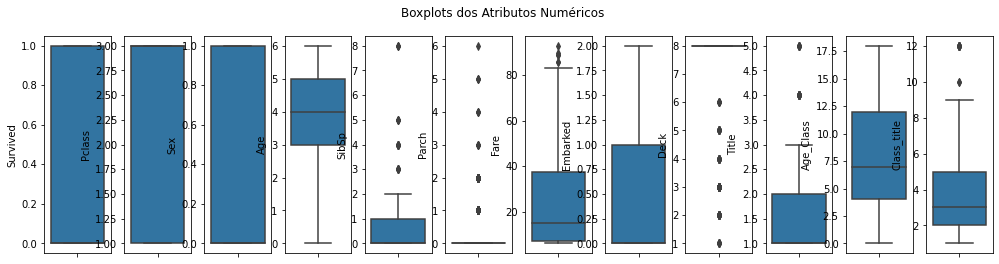

In [ ]:
#Visualizações de outliers
fig, ax = plt.subplots(ncols=len(numericos), nrows=1)
plt.suptitle("Boxplots dos Atributos Numéricos")

# Gráfico para cada atributo numérico
for i in range(0, len(numericos)):
    feature = numericos[i]
    sns.boxplot(train[feature], ax=ax[i], orient='vertical')

In [ ]:
print('Total de passageiros no dataset de TREINO {}'.format(train.shape[0]))
print('Total de passageiros com todos registros preenchidos(linhas) {}'.format(train.dropna().shape[0]))
print('Percentual de dados com 100% do preenchimento dos dados {}'.format(train.dropna().shape[0]/len(train)* 100,2))

Total de passageiros no dataset de TREINO 436
Total de passageiros com todos registros preenchidos(linhas) 436
Percentual de dados com 100% do preenchimento dos dados 100.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


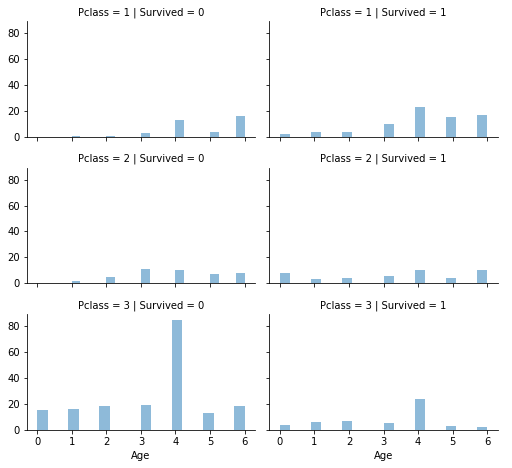

In [ ]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

# Removing outliers

### Fare

In [ ]:
IQR=train.Fare.describe()[6]-train.Fare.describe()[4]
quartil_superior_fa=train.Fare.quantile(0.75) + (IQR*3)
quartil_inferior_fa=train.Fare.quantile(0.25) - (IQR*3)
print('Os valores de Fare que serão considerados OUtliers estão entre {a} e {b}'.format(b=quartil_inferior_fa,a=quartil_superior_fa))
print('Quantidade de registros que serão alterados para o quartil superior {}'.format(train[train['Fare']>99].count()[0]))

Os valores de Fare que serão considerados OUtliers estão entre 111.26660000000001 e -69.58120000000001
Quantidade de registros que serão alterados para o quartil superior 41


In [ ]:
train[train['Fare']>99]['Pclass'].value_counts()

1    41
Name: Pclass, dtype: int64

In [ ]:
train[(train['Pclass']==1) & (train['Fare']<99)]['Fare'].mean()


50.96068547008548

In [ ]:
train[(train['Pclass']==1)]['Fare'].mean()

86.0894784810126

In [ ]:
def fare_outlier(df):
  df['Fare']=np.where(df['Fare']>99, np.random.randint(35,50,1)[0],df['Fare'])

  print(df.groupby('Pclass')['Fare'].mean())

  df['Fare']=np.where(((df['Fare']==0)&(df['Pclass']==1)),49,df['Fare'])
  df['Fare']=np.where(((df['Fare']==0)&(df['Pclass']==2)),20,df['Fare'])
  df['Fare']=np.where(((df['Fare']==0)&(df['Pclass']==3)),14,df['Fare'])

In [ ]:
fare_outlier(train)

Pclass
1    49.154432
2    21.699865
3    14.013314
Name: Fare, dtype: float64


In [ ]:
 
def pclass_by_fare(df): 
    df['Pclass']=np.where((df['Pclass'].isnull())&(df['Pclass']<14.99),3,df['Pclass'])
    df['Pclass']=np.where((df['Pclass'].isnull())&(df['Pclass']>=14.99)&(df['Pclass']<44.99),2,df['Pclass'])
    df['Pclass']=np.where((df['Pclass'].isnull())&(df['Pclass']>=44.99),1,df['Pclass'])

In [ ]:
pclass_by_fare(train)

#Functions

###Missing Data

####Cabin

In [ ]:
import re

def func_deck(dataframe):
  deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
  data_deck = [dataframe]

  for dataset in data_deck:
      dataset['Cabin'] = dataset['Cabin'].fillna("U0")
      dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
      dataset['Deck'] = dataset['Deck'].map(deck)
      dataset['Deck'] = dataset['Deck'].fillna(0)
      dataset['Deck'] = dataset['Deck'].astype(int)
  


####Age

In [ ]:

def func_age(dataframe):
  data_age = [dataframe]

  for dataset in data_age:
      median= dataframe["Age"].mean()
      #std = dataframe["Age"].std()
      #is_null = dataframe["Age"].isnull().sum()
      # compute random numbers between the mean, std and is_null
      #rand_age = np.random.randint(mean - std, mean + std, size = is_null)
      # fill NaN values in Age column with random values generated
      age_slice = dataset["Age"].copy()
      age_slice[np.isnan(age_slice)] = median
      dataset["Age"] = age_slice
      dataset["Age"] = dataframe["Age"].astype(int)


####Embarked

In [ ]:
def func_common_value(dataframe):
  common_value = 'S'
  data_em = [dataframe]

  for dataset in data_em:
      dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

###Converting Features

####Fare


In [ ]:
def func_fare_int(dataframe):
  data_fare = [dataframe]

  for dataset in data_fare:
      dataset['Fare'] = dataset['Fare'].fillna(0)
      dataset['Fare'] = dataset['Fare'].astype(int)

####Name

In [ ]:
def func_name(dataframe):
  data_name = [dataframe]
  titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

  for dataset in data_name:
      # extract titles
      dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
      # replace titles with a more common title or as Rare
      dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
      dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
      dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
      dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
      # convert titles into numbers
      dataset['Title'] = dataset['Title'].map(titles)
      # filling NaN with 0, to get safe
      dataset['Title'] = dataset['Title'].fillna(0)
  


####Sex

In [ ]:


def func_sex(dataframe):
  data_sex = [dataframe]

  for dataset in data_sex:
      dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})
    

####Embarked

In [ ]:

def func_Em_dummies(dataframe):
  
  ports = {"S": 0, "C": 1, "Q": 2}
  data = [dataframe]

  for dataset in data:
      dataset['Embarked'] = dataset['Embarked'].map(ports)
     

###Creating Categories

####Age

In [ ]:

def func_age_slice(dataframe):
  data = [dataframe]
  for dataset in data:
      dataset['Age'] = dataset['Age'].astype(int)
      dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
      dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
      dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
      dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
      dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
      dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
      dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
      dataset.loc[ dataset['Age'] > 66, 'Age'] = 6



####Fare

####SibSp and Parch

In [ ]:
'''
def func_not_alone(dataframe):
  data = [dataframe]
  for dataset in data:
      dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
      dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
      dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
      dataset['not_alone'] = dataset['not_alone'].astype(int)
  dataframe['not_alone'].value_counts()
'''

###Creating new Features

####Age times Class

In [ ]:
def func_age_class(dataframe):
  data = [dataframe]
  for dataset in data:
      dataset['Age_Class']= dataset['Age']* dataset['Pclass']

####Fare per Person

In [ ]:
'''def func_fare_person(dataframe):
  data = [dataframe]
  for dataset in data:
      dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
      dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)'''

####Class times title

In [ ]:
def func_class_title(dataframe):
  data = [dataframe]
  for dataset in data:
      dataset['Class_title']= dataset['Pclass']* dataset['Title']

#Training and validation division

In [ ]:
# divisão do dataset em treino e teste
train, test_split = train_test_split(train.copy(), test_size=0.20)

In [ ]:
test_split.to_csv('./test_split.csv', index=False)

#Modeling for training


In [ ]:
func_deck(train)
func_age(train)
func_common_value(train)
func_fare_int(train)
func_name(train)
func_sex(train)
func_Em_dummies(train)
func_age_slice(train)
#func_fare_slice(train)
#func_not_alone(train)
func_age_class(train)
#func_fare_person(train)
func_class_title(train)



In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Age_Class,Class_title
266,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,5,1,1,110413,79,E67,0,5,3,5,3
166,599,0,3,"Boulos, Mr. Hanna",0,4,0,0,2664,7,U0,1,8,1,12,3
563,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",1,6,1,4,347088,27,U0,0,8,3,18,9
100,661,1,1,"Frauenthal, Dr. Henry William",0,6,2,0,PC 17611,44,U0,0,8,5,6,5
357,866,1,2,"Bystrom, Mrs. (Karolina)",1,6,0,0,236852,13,U0,0,8,3,12,6


In [ ]:
#DROPS
train.drop('Ticket', axis=1, inplace=True)   
train.drop('Cabin', axis=1, inplace=True)  
train.drop('Name', axis=1, inplace=True)  
#train.drop('Embarked', axis=1, inplace=True) 
 

##Final look before trainning

In [ ]:
train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
610,241,0,3,1,4,1,0,14,1,8,2,12,6
19,850,1,1,1,4,1,0,89,1,3,3,4,3
364,342,1,1,1,3,3,2,41,0,3,2,3,2
519,304,1,2,1,4,0,0,12,2,5,2,8,4
603,182,0,2,0,4,0,0,15,1,8,1,8,2
533,534,1,3,1,4,0,2,22,1,8,3,12,9
62,14,0,3,0,5,1,5,31,0,8,1,15,3
353,646,1,1,0,6,1,0,76,1,4,1,6,1
422,775,1,2,1,6,1,3,23,0,8,3,12,6
415,215,0,3,0,4,1,0,7,2,8,1,12,3


In [ ]:
train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,0.405963,2.275229,0.348624,29.084862,0.580275,0.440367,1.628440,0.362385,6.850917,1.779817,62.577982,3.910550
std,0.491642,0.850926,0.477082,12.983974,1.188247,0.885969,1.255615,0.626509,2.173672,1.073037,32.563725,2.657244
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,22.750000,0.000000,0.000000,1.000000,0.000000,8.000000,1.000000,37.000000,2.000000
50%,0.000000,3.000000,0.000000,29.000000,0.000000,0.000000,2.000000,0.000000,8.000000,1.000000,62.000000,3.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,1.000000,3.000000,1.000000,8.000000,2.000000,87.000000,6.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,5.000000,2.000000,8.000000,5.000000,210.000000,12.000000


In [ ]:
display(train.dtypes)

PassengerId    int64
Survived       int64
Pclass         int64
Sex            int64
Age            int64
SibSp          int64
Parch          int64
Fare           int64
Embarked       int64
Deck           int64
Title          int64
Age_Class      int64
Class_title    int64
dtype: object

#### Salvando a coluna Survived e retirando a coluna PassengerID

In [ ]:
train = train.drop("PassengerId", axis=1)

#####Gravar conjuntos de treino pré-processado

In [ ]:
train.to_csv('./train-preprocessado.csv', index=False)

#Training

##Loading the training dataframe

Carregar dataset
Nesse momento, o dataset já está pré-processado.

In [ ]:
dataset = pd.read_csv('./train-preprocessado.csv')
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
0,1,1,1,5,1,1,79,0,5,3,5,3
1,0,3,0,4,0,0,7,1,8,1,12,3
2,0,3,1,6,1,4,27,0,8,3,18,9
3,1,1,0,6,2,0,44,0,8,5,6,5
4,1,2,1,6,0,0,13,0,8,3,12,6


##Random Forest

In [ ]:

'''param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV, cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(X, y)
clf.bestparams'''


'param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}\nfrom sklearn.model_selection import GridSearchCV, cross_val_score\nrf = RandomForestClassifier(n_estimators=100, max_features=\'auto\', oob_score=True, random_state=1, n_jobs=-1)\nclf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)\nclf.fit(X, y)\nclf.bestparams'

In [ ]:
#retirando os menos importantes para melhorar o resultado do random forest
#dataset = dataset.drop('SibSp', axis=1)  
#dataset = dataset.drop('Parch', axis=1) 
dataset = dataset.drop('Title', axis=1) 
#dataset = dataset.drop('Embarked', axis=1)
#dataset = dataset.drop('Deck', axis=1)
dataset = dataset.drop('Age', axis=1)
#dataset = dataset.drop('Age_Class', axis=1)
dataset = dataset.drop('Class_title', axis=1)
#dataset = dataset.drop('Pclass', axis=1)
#dataset = dataset.drop('Fare', axis=1)

In [ ]:
X = dataset.drop(['Survived'], axis=1)
y = dataset['Survived']

In [ ]:
model = RandomForestClassifier(criterion = "gini",min_samples_leaf = 1, 
                                       min_samples_split = 2,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=False, 
                                       random_state=1, 
                                       n_jobs=-1,warm_start=False)

model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = model.predict(X)

In [ ]:
accuracy_score(y, y_pred)

0.9497991967871486

In [ ]:

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       307
           1       0.96      0.91      0.93       191

    accuracy                           0.95       498
   macro avg       0.95      0.94      0.95       498
weighted avg       0.95      0.95      0.95       498



In [ ]:
joblib.dump(model, filename='./model_RandomF.pkl')

['./model_RandomF.pkl']

##Decision Tree

In [ ]:
'''
decision_tree = DecisionTreeClassifier() decision_tree.fit(X_train, Y_train) 
 Y_pred = decision_tree.predict(X_test)  
 acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
'''

In [ ]:
#dataset = dataset.drop('not_alone', axis=1)  
#dataset = dataset.drop('Parch', axis=1) 
#dataset = dataset.drop('Sex', axis=1) 

In [ ]:
X = dataset.drop(['Survived'], axis=1)
y = dataset['Survived']

In [ ]:
model=DecisionTreeClassifier(random_state=1)
model.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
y_pred = model.predict(X)
acc_decision_tree = round(model.score(X, y) * 100, 2)
y_proba = model.predict_proba(X)

In [ ]:
# acurácia
accuracy_score(y, y_pred)

0.9357945425361156

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       377
           1       0.97      0.87      0.91       246

    accuracy                           0.94       623
   macro avg       0.94      0.92      0.93       623
weighted avg       0.94      0.94      0.94       623



Text(0.5, 15.0, 'Predicted label')

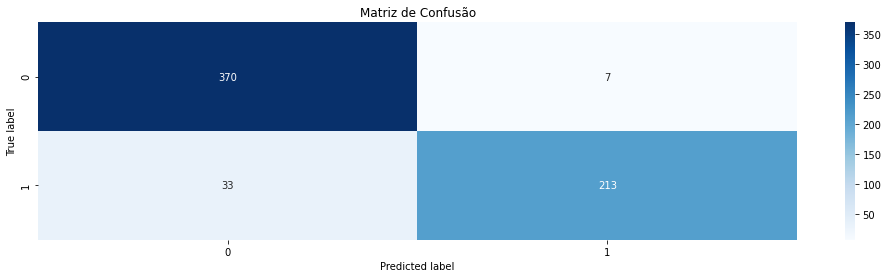

In [ ]:
# gerando a matriz confusão
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
joblib.dump(model, filename='./model_dec_tree.pkl')

['./model_dec_tree.pkl']

##Logistic Regression

In [ ]:
'''
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
'''

In [ ]:
X = dataset.drop(['Survived'], axis=1)
y = dataset['Survived']

In [ ]:
model=LogisticRegression()
model.fit(X, y)
Y_pred = model.predict(X)

In [ ]:
# acurácia
accuracy_score(y, Y_pred)

0.8089887640449438

In [ ]:
print(classification_report(y, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       377
           1       0.77      0.74      0.75       246

    accuracy                           0.81       623
   macro avg       0.80      0.80      0.80       623
weighted avg       0.81      0.81      0.81       623



Text(0.5, 15.0, 'Predicted label')

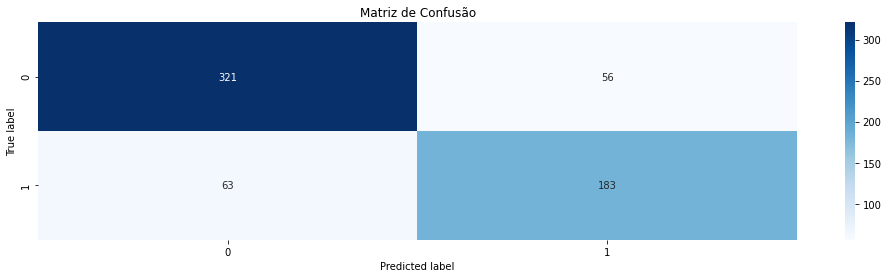

In [ ]:
# gerando a matriz confusão
cm = confusion_matrix(y, Y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
joblib.dump(model, filename='./model_logistic.pkl')

['./model_logistic.pkl']

#Validation

##Loading the 30% training dataframe (validation)

In [ ]:
test_split = pd.read_csv('./test_split.csv')
test_split.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,619,1,2,"Becker, Miss. Marion Louise",female,4.0,2,1,230136,39.0000,F4,S
1,709,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S
2,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
3,579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
4,384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,113789,52.0000,NaN,S


##Modeling for Test_split

In [ ]:
func_deck(test_split)
func_age(test_split)
func_common_value(test_split)
func_fare_int(test_split)
func_name(test_split)
func_sex(test_split)
func_Em_dummies(test_split)
func_age_slice(test_split)
#func_fare_slice(test_split)
#func_not_alone(test_split)
func_age_class(test_split)
#func_fare_person(test_split)
func_class_title(test_split)


In [ ]:
#DROPS
test_split.drop('Ticket', axis=1, inplace=True)   
test_split.drop('Cabin', axis=1, inplace=True)   
test_split.drop('Name', axis=1, inplace=True)  

## Final look before trainning

In [ ]:
test_split.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
0,619,1,2,1,0,2,1,39,0,6,2,0,4
1,709,1,1,1,2,0,0,151,0,8,2,2,2
2,883,0,3,1,2,0,0,10,0,8,2,6,6
3,579,0,3,1,4,1,0,14,1,8,3,12,9
4,384,1,1,1,5,1,0,52,0,8,3,5,3
5,23,1,3,1,1,0,0,8,2,8,2,3,6
6,113,0,3,0,2,0,0,8,0,8,1,6,3
7,68,0,3,0,2,0,0,8,0,8,1,6,3
8,228,0,3,0,2,0,0,7,0,8,1,6,3
9,226,0,3,0,2,0,0,9,0,8,1,6,3


### Salvando a coluna Survived e retirando a coluna PassengerID

In [ ]:
test_split = test_split.drop("PassengerId", axis=1)


In [ ]:
test_split.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
0,1,3,1,4,0,0,7,2,8,2,12,6
1,0,2,0,6,0,0,26,0,8,1,12,2
2,0,2,0,6,0,0,15,0,8,1,12,2
3,0,1,0,3,0,2,39,1,3,1,3,1
4,0,1,0,6,2,0,90,2,3,5,6,5


##Decision Tree

In [ ]:
model = joblib.load('./model_dec_tree.pkl') #carregando o modelo treinado

In [ ]:
'''
decision_tree = DecisionTreeClassifier() decision_tree.fit(X_train, Y_train) 
 Y_pred = decision_tree.predict(X_test)  
 acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
'''

'\ndecision_tree = DecisionTreeClassifier() decision_tree.fit(X_train, Y_train) \n Y_pred = decision_tree.predict(X_test)  \n acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)\n'

In [ ]:
#test_split = test_split.drop('not_alone', axis=1)  
#test_split = test_split.drop('Parch', axis=1)
dt = test_split 
#dt = dt.drop('Sex', axis=1) 

In [ ]:
X=dt.drop("Survived", axis=1)
y=dt['Survived']

In [ ]:
y_pred = model.predict(X)
acc_decision_tree = round(model.score(X, y) * 100, 2)
y_proba = model.predict_proba(X)

In [ ]:
# acurácia
accuracy_score(y, y_pred)

0.9358288770053476

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       117
           1       0.98      0.84      0.91        70

    accuracy                           0.94       187
   macro avg       0.95      0.92      0.93       187
weighted avg       0.94      0.94      0.93       187



Text(0.5, 15.0, 'Predicted label')

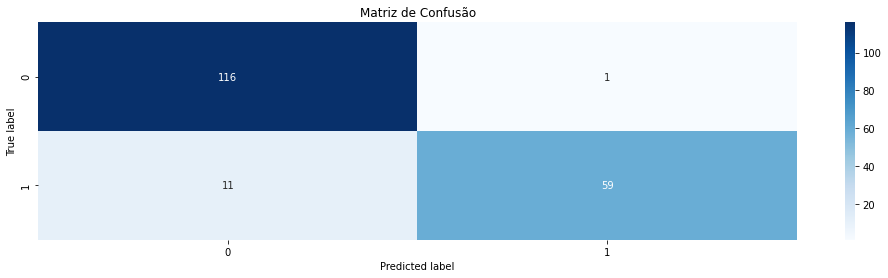

In [ ]:
# gerando a matriz confusão
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
fp, tp, thresholds = roc_curve(y, y_proba[:, 1])

Text(0.5, 1.0, 'Curva ROC')

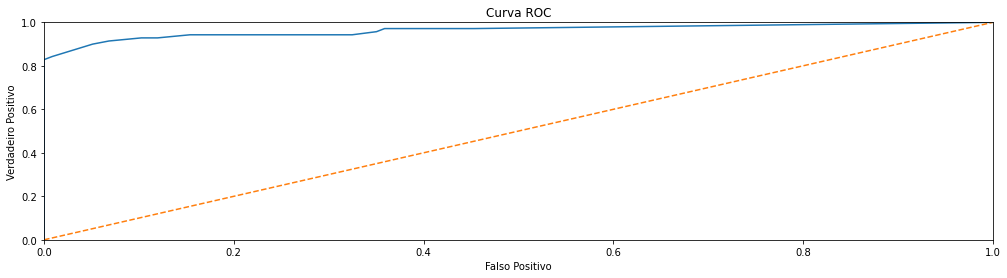

In [ ]:
# Gerando a Curva ROC
plt.plot(fp, tp)

plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')

In [ ]:
# Área sob a curva ROC
auc(fp, tp)

0.9635531135531137

## Random Forest


In [ ]:
model = joblib.load('./model_RandomF.pkl') #carregando o modelo treinado

In [ ]:
#test_split = test_split.drop('SibSp', axis=1) 
#test_split = test_split.drop('Parch', axis=1) 
#test_split = test_split.drop('Embarked', axis=1) 
test_split = test_split.drop('Title', axis=1) 
#test_split = test_split.drop('Deck', axis=1)
#test_split = test_split.drop('Age_Class', axis=1) 
#test_split = test_split.drop('Age', axis=1) 
test_split = test_split.drop('Class_title', axis=1)
#test_split = test_split.drop('Pclass', axis=1)
#test_split = test_split.drop('Fare', axis=1)


In [ ]:
test_split.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class
0,1,2,1,2,1,39,0,6,2,0
1,1,1,1,0,0,151,0,8,2,2
2,0,3,1,0,0,10,0,8,2,6
3,0,3,1,1,0,14,1,8,3,12
4,1,1,1,1,0,52,0,8,3,5


In [ ]:
X_test = test_split.drop(['Survived'], axis=1)
y_test = test_split['Survived']

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Text(0.5, 15.0, 'Predicted label')

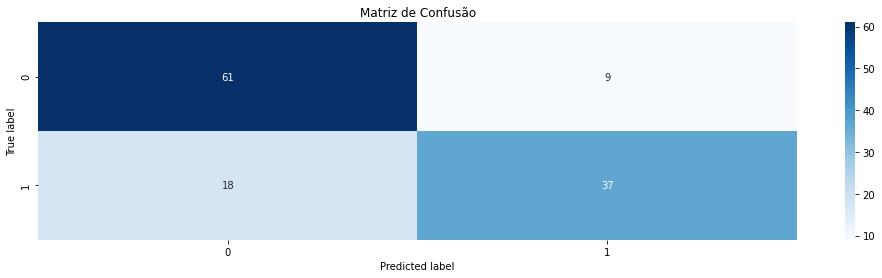

In [ ]:
# gerando a matriz confusão
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
accuracy_score(y_test, y_pred)

0.784

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        70
           1       0.80      0.67      0.73        55

    accuracy                           0.78       125
   macro avg       0.79      0.77      0.78       125
weighted avg       0.79      0.78      0.78       125



In [ ]:
fp, tp, thresholds = roc_curve(y_test, y_proba[:, 1])

Text(0.5, 1.0, 'Curva ROC')

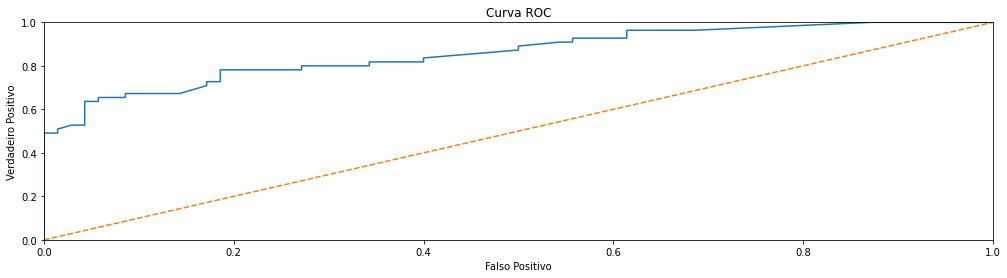

In [ ]:
# Gerando a Curva ROC
plt.plot(fp, tp)

plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')

In [ ]:
# Área sob a curva ROC
auc(fp, tp)

0.8589610389610389

##Logistic Regression

In [ ]:
model = joblib.load('./model_logistic.pkl') #carregando o modelo treinado

In [ ]:
'''
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
'''

'\nlogreg = LogisticRegression()\nlogreg.fit(X_train, Y_train)\n\nY_pred = logreg.predict(X_test)\n\nacc_log = round(logreg.score(X_train, Y_train) * 100, 2)\n'

In [ ]:
test_split.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,relatives,not_alone,Age_Class,Fare_Per_Person,Class_title
0,0,3,0,3,2,0,2,0,8,1,2,0,9,0,3
1,0,3,1,4,1,1,2,0,8,3,2,0,12,0,9
2,1,2,1,5,0,0,1,0,8,2,0,1,10,1,4
3,0,3,0,0,4,1,3,0,8,4,5,0,0,0,12
4,0,3,0,4,0,0,1,0,8,1,0,1,12,1,3


In [ ]:
X=test_split.drop("Survived", axis=1)
y=test_split['Survived']

In [ ]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

In [ ]:
accuracy_score(y, y_pred)

0.8021390374331551

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       117
           1       0.71      0.79      0.75        70

    accuracy                           0.80       187
   macro avg       0.79      0.80      0.79       187
weighted avg       0.81      0.80      0.80       187



Text(0.5, 15.0, 'Predicted label')

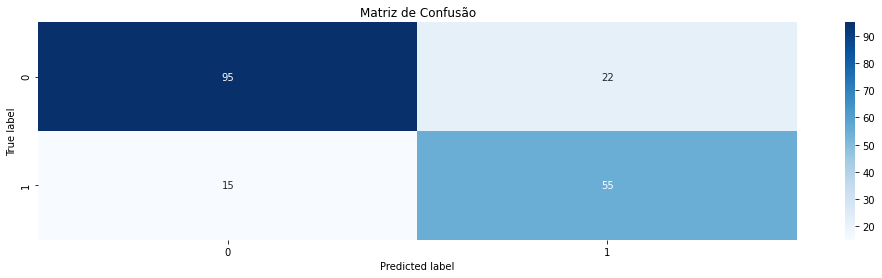

In [ ]:
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
fp, tp, thresholds = roc_curve(y, y_proba[:, 1])

Text(0.5, 1.0, 'Curva ROC')

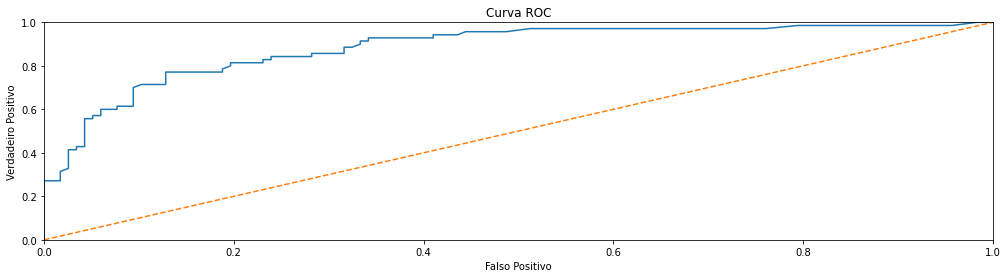

In [ ]:
# Gerando a Curva ROC
plt.plot(fp, tp)

plt.plot([0, 1], [0, 1], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')

In [ ]:
# Área sob a curva ROC
auc(fp, tp)

0.8838217338217339

#Prediction with test dataset for competition submission


##Loading dataframe

In [ ]:
validation = pd.read_csv('./test.csv')
validation.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,132,3,"Coelho, Mr. Domingos Fernandeo",male,20.00,0,0,SOTON/O.Q. 3101307,7.0500,NaN,S
1,39,3,"Vander Planke, Miss. Augusta Maria",female,18.00,2,0,345764,18.0000,NaN,S
2,756,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
3,660,1,"Newell, Mr. Arthur Webster",male,58.00,0,2,35273,113.2750,D48,C
4,799,3,"Ibrahim Shawah, Mr. Yousseff",male,30.00,0,0,2685,7.2292,NaN,C


In [ ]:
identificador = validation[['PassengerId']]

##Competition Modeling


In [ ]:
func_deck(validation)
func_age(validation)
func_common_value(validation)
func_fare_int(validation)
func_name(validation)
func_sex(validation)
func_Em_dummies(validation)
func_age_slice(validation)
#func_fare_slice(validation)
#func_not_alone(validation)
func_age_class(validation)
#func_fare_person(validation)
func_class_title(validation)


In [ ]:
#DROPS
validation.drop('Ticket', axis=1, inplace=True)   
validation.drop('Cabin', axis=1, inplace=True)  
validation.drop('Name', axis=1, inplace=True)  
#validation.drop('Embarked', axis=1, inplace=True) 

## Final look before running

In [ ]:
validation.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
0,132,3,0,2,0,0,7,0,8,1,6,3
1,39,3,1,1,2,0,18,0,8,2,3,6
2,756,2,0,0,1,1,14,0,8,4,0,8
3,660,1,0,6,0,2,113,1,4,1,6,1
4,799,3,0,4,0,0,7,1,8,1,12,3
5,683,3,0,2,0,0,9,0,8,1,6,3
6,840,1,0,4,0,0,29,1,3,1,4,1
7,706,2,0,5,0,0,26,0,8,1,10,2
8,122,3,0,4,0,0,8,0,8,1,12,3
9,115,3,1,1,0,0,14,1,8,2,3,6


In [ ]:
validation.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,Age_Class,Class_title
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,431.186567,2.339552,0.317164,3.559701,0.492537,0.343284,28.059701,0.317164,7.014925,1.682836,7.902985,3.802239
std,270.945388,0.812129,0.466243,1.746098,1.143267,0.755549,45.874240,0.618204,1.965946,1.049418,4.467728,2.537006
min,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,177.250000,2.000000,0.000000,2.000000,0.000000,0.000000,7.000000,0.000000,8.000000,1.000000,5.000000,2.000000
50%,439.000000,3.000000,0.000000,4.000000,0.000000,0.000000,13.000000,0.000000,8.000000,1.000000,8.000000,3.000000
75%,677.000000,3.000000,1.000000,5.000000,1.000000,0.000000,27.000000,0.000000,8.000000,2.000000,12.000000,5.250000
max,887.000000,3.000000,1.000000,6.000000,8.000000,5.000000,512.000000,2.000000,8.000000,5.000000,18.000000,12.000000


#### Retirando a coluna PassengerID

In [ ]:
validation = validation.drop("PassengerId", axis=1)

##Random Forest

In [ ]:
model = joblib.load('./model_RandomF.pkl') #carregando o modelo treinado

In [ ]:
#validation = validation.drop("Parch", axis=1)
#validation = validation.drop('SibSp', axis=1)
#validation = validation.drop("Embarked", axis=1)
#validation = validation.drop("Title", axis=1)
validation = validation.drop("Age_Class", axis=1)
#validation = validation.drop("Pclass", axis=1)
validation = validation.drop("Class_title", axis=1)
#validation = validation.drop("Fare", axis=1)
validation = validation.drop("Age", axis=1)


In [ ]:
validation.head(15)

,Sex,Age,SibSp,Parch,Fare,Deck,Title
0,0,2,0,0,7,8,1
1,1,1,2,0,18,8,2
2,0,0,1,1,14,8,4
3,0,6,0,2,113,4,1
4,0,4,0,0,7,8,1
5,0,2,0,0,9,8,1
6,0,4,0,0,29,3,1
7,0,5,0,0,26,8,1
8,0,4,0,0,8,8,1
9,1,1,0,0,14,8,2


In [ ]:
y_pred = model.predict_proba(validation)
y_pred = y_pred[:, 1]

In [ ]:
resultado = pd.concat([identificador, pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
resultado.head()

,PassengerId,Survived
0,132,0.071891
1,39,0.690000
2,756,0.797912
3,660,0.800000
4,799,0.149520


In [ ]:
# gerando arquivos para submissão na competição
resultado.to_csv('random_F.csv', index=False)

In [ ]:
from google.colab import files
files.download("random_F.csv")

In [ ]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X, y, cv=10, scoring = "accuracy")

In [ ]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.72       0.84       0.86       0.76       0.84       0.72
 0.84       0.82       0.75510204 0.91836735]
Mean: 0.8073469387755102
Standard Deviation: 0.06219877849803186


In [ ]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Fare,0.267
Title,0.228
Sex,0.180
Pclass,0.081
Deck,0.073
SibSp,0.066
Parch,0.065
Embarked,0.040


##Decision Tree

In [ ]:
model = joblib.load('./model_dec_tree.pkl') #carregando o modelo treinado

In [ ]:
#decision_tree = DecisionTreeClassifier() decision_tree.fit(X_train, Y_train)  Y_pred = decision_tree.predict(X_test)  acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

In [ ]:
#validation = validation.drop('not_alone', axis=1)  
#validation = validation.drop('Parch', axis=1) 
validation = validation.drop('Sex', axis=1) 

In [ ]:
y_pred = model.predict_proba(validation)
y_pred = y_pred[:, 1]

In [ ]:
resultado = pd.concat([identificador, pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
resultado.head()

,PassengerId,Survived
0,132,0.058824
1,39,1.000000
2,756,1.000000
3,660,0.000000
4,799,0.166667


In [ ]:
# gerando arquivos para submissão na competição
resultado.to_csv('decicion_tree.csv', index=False)

In [ ]:
from google.colab import files
files.download("decicion_tree.csv")

In [ ]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.428
Pclass,0.099
Deck,0.070
relatives,0.067
Age_Class,0.065
Fare,0.055
Age,0.046
Fare_Per_Person,0.043
SibSp,0.035


##Logistic Regression

In [ ]:
model = joblib.load('./model_logistic.pkl') #carregando o modelo treinado

In [ ]:
'''
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
'''

'\nlogreg = LogisticRegression()\nlogreg.fit(X_train, Y_train)\n\nY_pred = logreg.predict(X_test)\n\nacc_log = round(logreg.score(X_train, Y_train) * 100, 2)\n'

In [ ]:
y_pred = model.predict_proba(validation)
y_pred = y_pred[:, 1]

In [ ]:
resultado = pd.concat([identificador, pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
resultado.head()

,PassengerId,Survived
0,132,0.121759
1,39,0.660043
2,756,0.508831
3,660,0.335654
4,799,0.081156


In [ ]:
# gerando arquivos para submissão na competição
resultado.to_csv('logistic_reg.csv', index=False)

In [ ]:
from google.colab import files
files.download("logistic_reg.csv")